# Erase Operator

In this example we demonstrate the capabilities of Erase operator and the different ways to specify its arguments.

The *Erase* operator can be used to remove parts of a tensor (e.g. an image) by specifying one or multiple regions together with a value to fill the erased regions.

Let's start by defining a DALI pipeline that we will be using to demonstrate the different use cases.

In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops            
import nvidia.dali.types as types
import matplotlib.pyplot as plt

batch_size = 1
image_filename = '../data/images'

class ErasePipeline(Pipeline):                   
    def __init__(self, anchor, shape, axis_names, fill_value=0, 
                 normalized_anchor=False, normalized_shape=False, centered_anchor=False, 
                 batch_size=1, num_threads=1, device_id=0):
        super(ErasePipeline, self).__init__(batch_size, num_threads, device_id, seed=1234)
        self.input_data = ops.FileReader(device="cpu", file_root=image_filename)
        self.decode = ops.ImageDecoder(device="cpu", output_type=types.RGB)
        self.erase = ops.Erase(device="cpu", 
                               anchor=anchor, 
                               shape=shape, 
                               axis_names=axis_names, 
                               fill_value=fill_value,
                               normalized_anchor=normalized_anchor,
                               normalized_shape=normalized_shape,
                               centered_anchor=centered_anchor)

    def define_graph(self):                                                                
        in_data, _ = self.input_data()
        images = self.decode(in_data)
        out = self.erase(images)        
        return out

We can now write a simple utility function to run and display the output of a pipeline instance

In [2]:
def show(pipe):
    pipe.build()
    out = pipe.run()
    plt.imshow(out[0].at(0))

We can now use the pipeline class to demostrate different use cases of the erase operator.

Lets start by specifying a rectangular region with an anchor and a rectangular shape specified with absolute coordinates. Note that the order of the axes in the *anchor* and *shape* arguments is described by the argument *axis_names*. The axis names specified need to be present in the layout of the input. For instance, layout="HWC" and axis_names="HW" is equivalent of saying that the first coordinate correspond to the axis with index 0 and the second coordinate corresponds to the axis with index 1. Alternative, the user can specified an argument *axes* with a list of axis indexes, e.g. axes=(0, 1). Using *axis_names* is preferred over *axes*.

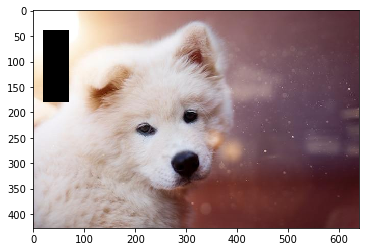

In [3]:
show(ErasePipeline(anchor=(40, 20), shape=(140, 50), axis_names="HW"))


The same region arguments could be interpreted differently if we change the value of *axis_names*. For example, layout="HWC" axis_names="WH" mean that the first coordinate refers to the axis with index 1 and the second one corresponds to the axis with index 0.

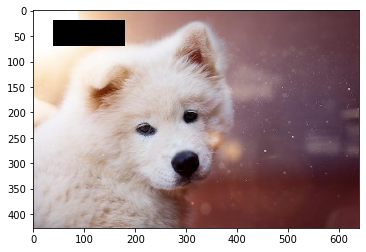

In [4]:
show(ErasePipeline(anchor=(40, 20), shape=(140, 50), axis_names="WH"))

We can specify a vertical or horizontal stripe by specifying only one dimension

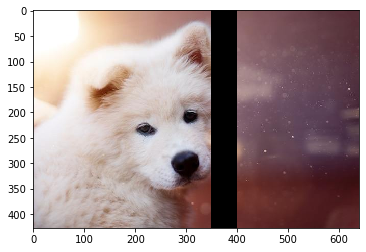

In [5]:
show(ErasePipeline(anchor=(350), shape=(50), axis_names="W"))

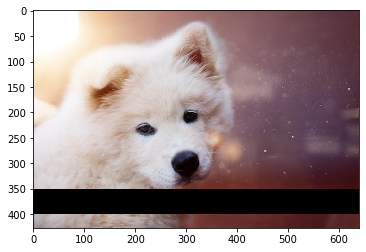

In [6]:
show(ErasePipeline(anchor=(350), shape=(50), axis_names="H"))

We can as well specifying multiple regions by adding more points to the *anchor* and *shape* arguments. For instance, an *anchor* and *shape* with 4 points and an argument *axis_names="HW"* representing 2 axes is interpreted as two regions *anchor=(y0, x0, y1, x1)* and *shape=(h0, w0, h1, w1)*

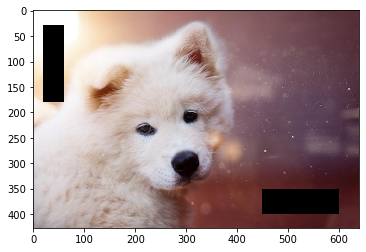

In [7]:
show(ErasePipeline(anchor=(30, 20, 350, 450), shape=(150, 40, 50, 150), axis_names="HW"))

Similarly, an *anchor* and *shape* with 3 elements representing only one axis (*axis_names="W"*), corresponds to 3 regions *anchor=(x0, x1, x2)* and *shape=(w0, w1, w2)*

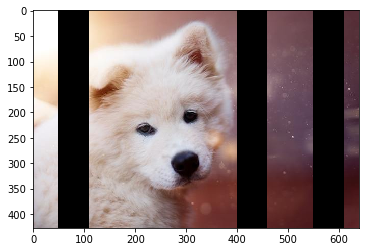

In [8]:
show(ErasePipeline(anchor=(50, 400, 550), shape=(60, 60, 60), axis_names="W"))

We can also change the default value for the erased regions. If a single *fill_value* is provided, it is used in all the channels

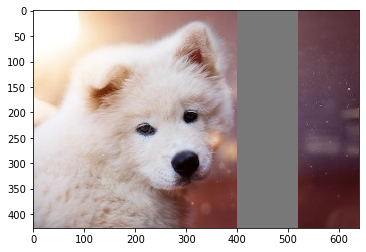

In [9]:
show(ErasePipeline(anchor=(400), shape=(120), axis_names="W", fill_value=120))

Alternatively, we can specify a multi-channel fill value, e.g. *fill_value=(118, 185, 0)*. In such case, the input layout should contain a *channels* 'C', e.g. "HWC". 

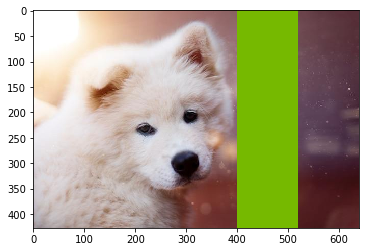

In [10]:
show(ErasePipeline(anchor=(400), shape=(120), axis_names="W", fill_value=(118, 185, 0)))

Regions that fall totally or partially out of bounds of the image are ignored or trimmed respectively. 

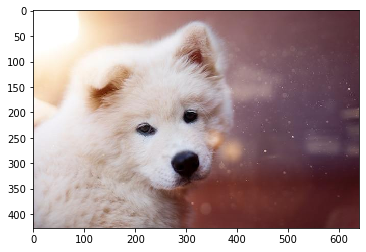

In [11]:
show(ErasePipeline(anchor=(800), shape=(120), axis_names="W", fill_value=(118, 185, 0)))

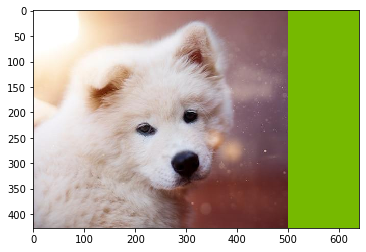

In [12]:
show(ErasePipeline(anchor=(500), shape=(500), axis_names="W", fill_value=(118, 185, 0)))

The region coordinates can be specified by relative coordinates as well. In that case, the relative coordinates will be multiplied by the input dimensions to obtain the absolute coordinates

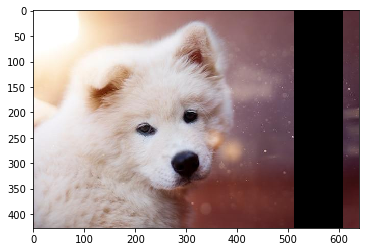

In [13]:
show(ErasePipeline(anchor=(0.8), shape=(0.15), axis_names="W", normalized_anchor=True, normalized_shape=True))

It is possible to use both relative and absolute coordinates to specify *anchor* and *shape* independently

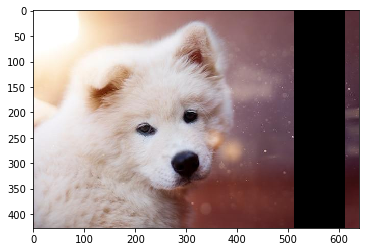

In [14]:
show(ErasePipeline(anchor=(0.8), shape=(100), axis_names="W", normalized_anchor=True, normalized_shape=False))

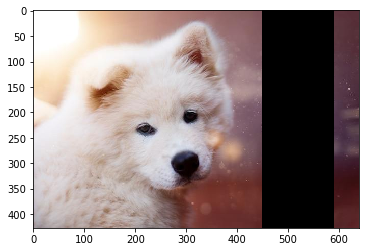

In [15]:
show(ErasePipeline(anchor=(450), shape=(0.22), axis_names="W", normalized_anchor=False, normalized_shape=True))

We can also specify that the regions should be centered at a given *anchor*, instead of starting at it. For this, we can use the boolean argument *centered_anchor*

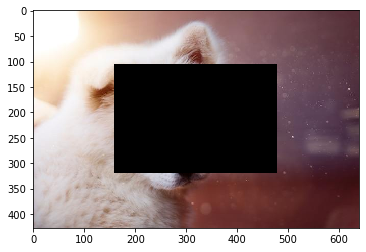

In [30]:
show(ErasePipeline(anchor=(0.5, 0.5), shape=(0.5, 0.5), axis_names="HW", 
                   centered_anchor=True, normalized_anchor=True, normalized_shape=True))

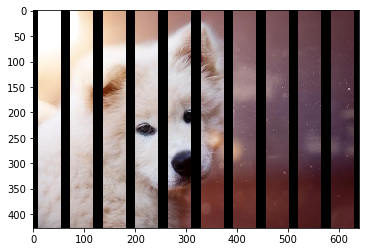

In [35]:
anchor = [k/10 for k in range(11)]
shape = [0.03] * 11
show(ErasePipeline(anchor=anchor, shape=shape, axis_names="W", 
                   centered_anchor=True, normalized_anchor=True, normalized_shape=True))

Last but not least, we can also use tensor inputs to specify the regions. For instance, we could use the output of a random number generator to feed the *anchor* and *shape* arguments of the *Erase* operator

In [17]:
class RandomErasePipeline(Pipeline):                   
    def __init__(self, batch_size=1, num_threads=1, device_id=0, axis_names="W", nregions=5):
        super(RandomErasePipeline, self).__init__(batch_size, num_threads, device_id, seed=1234)
        self.input_data = ops.FileReader(device="cpu", file_root=image_filename)
        self.decode = ops.ImageDecoder(device="cpu", output_type=types.RGB)
        ndims = len(axis_names)
        args_shape=(ndims*nregions,)
        self.random_anchor = ops.Uniform(range = (0., 1.), shape = args_shape)
        self.random_shape = ops.Uniform(range = (20., 50), shape = args_shape)
        self.erase = ops.Erase(device="cpu", 
                               axis_names=axis_names, 
                               fill_value=(118, 185, 0),
                               normalized_anchor=True,
                               normalized_shape=False)

    def define_graph(self):                                                                
        in_data, _ = self.input_data()
        images = self.decode(in_data)
        out = self.erase(images, anchor=self.random_anchor(), shape=self.random_shape())        
        return out

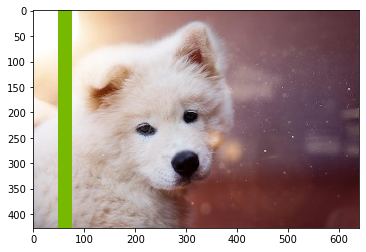

In [36]:
show(RandomErasePipeline(axis_names="W", nregions=1))

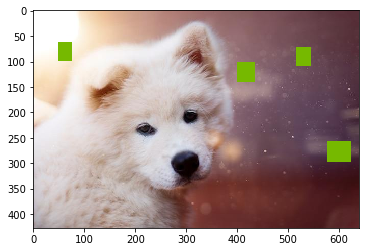

In [18]:
show(RandomErasePipeline(axis_names="WH", nregions=4))

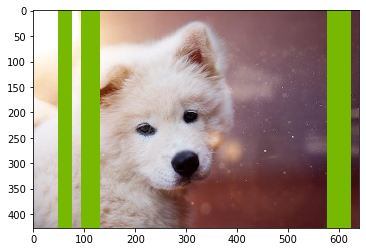

In [19]:
show(RandomErasePipeline(axis_names="W", nregions=3))